In [1]:
# Import the data and label coordinates



# Create label maps from the coordinates



In [2]:
import matplotlib.pyplot as plt
import matplotlib as matplt
from torchvision import models, transforms
from PIL import Image

loader = transforms.Compose([
  #transforms.Resize(img_size),
  #transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 

def load_image(filename, volatile=False):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
 
    '''
    #increase contrast
    hist, bins = np.histogram(image.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    image = cdf[image]
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(3.0)
    '''
    
    image_tensor = loader(image).float()
    return image_tensor
    #image_var = Variable(image_tensor, volatile=volatile).unsqueeze(0)
    #return image_var.cuda

plt.imshow(load_image('data/2nirecog/undistorted/101_left.jpg').numpy().transpose(1,2,0))

In [3]:
import torch
import torch.nn.functional as F
from torch import nn
CPU_DEBUG = False

# Setup the model
%env CUDA_LAUNCH_BLOCKING=1
device = torch.device("cpu" if CPU_DEBUG else "cuda")

class CoarseFireDetector(nn.Module):
    # Your code goes here
    def __init__(self):
        super(CoarseFireDetector, self).__init__()
                                                #input_channels, output_channels, kernel_size
        self.layers = nn.ModuleList([nn.Conv2d(3, 16, 5, stride=1, bias=True)])
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(16, 16, 5, stride=2, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(16, 8, 5, stride=1, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(8, 8, 3, stride=1, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(8, 1, 3, stride=1, bias=True))
        #self.layers.append(nn.Sigmoid())
    
    def forward(self, input):
        out = input 
        print(input.dim())
        if input.dim() == 3:
            out = out.unsqueeze(0)
            for layer in self.layers:
                out = layer(out)
            return out.squeeze()
        else:
            for layer in self.layers:
                out = layer(out)
            return out 
    

env: CUDA_LAUNCH_BLOCKING=1


3
torch.Size([228, 308])


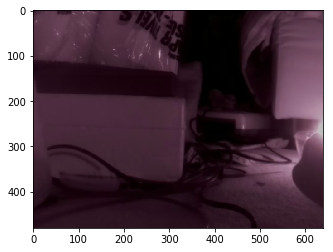

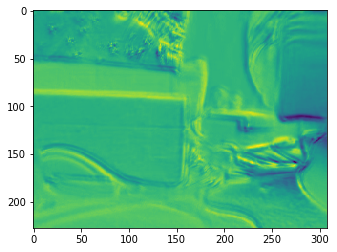

In [4]:
cf_detector = CoarseFireDetector().cuda()
out = cf_detector(load_image('data/2nirecog/undistorted/101_left.jpg').cuda())
print(out.size())
plt.imshow(load_image('data/2nirecog/undistorted/101_left.jpg').numpy().transpose(1,2,0))
plt.show()
plt.imshow(out.cpu().detach().numpy())
label_shape = out.cpu().detach().numpy().shape

In [5]:
import os
import pickle
import pprint
import random

def show_torch_img(tensor):
    plt.imshow(tensor.detach().cpu().numpy().transpose(1,2,0))
    #plt.show()

pp = pprint.PrettyPrinter(indent=2)

# Training Dataset
data = "data/2nirbienvs/undistorted"
metadp = "metadata.dat"
metadata = None
with open(os.path.join(data, metadp), 'rb') as metadf:
    metadata = pickle.load(metadf)
    #metadata = dict((k,metadata[k]) for k in range(478))
    #pp.pprint(metadata)

# load the input imgs
input_imgs = []
coords = []
for i, num in enumerate(metadata):
    print(metadata[num])
    input_imgs.append(load_image(metadata[num]['left']['img_path']))
    coords.append(metadata[num]['left']['coords'])
    input_imgs.append(load_image(metadata[num]['right']['img_path']))
    coords.append(metadata[num]['right']['coords'])
    #print(coords[-2])
    #show_torch_img(input_imgs[-2])
    #show_torch_img(input_imgs[-1])

{'left': {'img_path': 'data/2nirecog/undistorted/0_left.jpg', 'coords': (251.5, 227.0)}, 'right': {'img_path': 'data/2nirecog/undistorted/0_right.jpg', 'coords': (143.5, 223.0)}}
{'left': {'img_path': 'data/2nirecog/undistorted/1_left.jpg', 'coords': (166.5, 238.5)}, 'right': {'img_path': 'data/2nirecog/undistorted/1_right.jpg', 'coords': (57.5, 237.5)}}
{'left': {'img_path': 'data/2nirecog/undistorted/2_left.jpg', 'coords': (95.0, 221.0)}, 'right': {'img_path': 'data/2nirecog/undistorted/2_right.jpg', 'coords': (None, None)}}
{'left': {'img_path': 'data/2nirecog/undistorted/3_left.jpg', 'coords': (226.5, 229.0)}, 'right': {'img_path': 'data/2nirecog/undistorted/3_right.jpg', 'coords': (110.5, 236.0)}}
{'left': {'img_path': 'data/2nirecog/undistorted/4_left.jpg', 'coords': (91.5, 143.0)}, 'right': {'img_path': 'data/2nirecog/undistorted/4_right.jpg', 'coords': (None, None)}}
{'left': {'img_path': 'data/2nirecog/undistorted/5_left.jpg', 'coords': (348.0, 148.0)}, 'right': {'img_path': '

{'left': {'img_path': 'data/2nirecog/undistorted/53_left.jpg', 'coords': (182.0, 224.0)}, 'right': {'img_path': 'data/2nirecog/undistorted/53_right.jpg', 'coords': (None, None)}}
{'left': {'img_path': 'data/2nirecog/undistorted/54_left.jpg', 'coords': (408.5, 213.5)}, 'right': {'img_path': 'data/2nirecog/undistorted/54_right.jpg', 'coords': (210.5, 222.0)}}
{'left': {'img_path': 'data/2nirecog/undistorted/55_left.jpg', 'coords': (None, None)}, 'right': {'img_path': 'data/2nirecog/undistorted/55_right.jpg', 'coords': (429.5, 239.0)}}
{'left': {'img_path': 'data/2nirecog/undistorted/56_left.jpg', 'coords': (163.0, 223.5)}, 'right': {'img_path': 'data/2nirecog/undistorted/56_right.jpg', 'coords': (None, None)}}
{'left': {'img_path': 'data/2nirecog/undistorted/57_left.jpg', 'coords': (10.0, 234.0)}, 'right': {'img_path': 'data/2nirecog/undistorted/57_right.jpg', 'coords': (None, None)}}
{'left': {'img_path': 'data/2nirecog/undistorted/58_left.jpg', 'coords': (272.0, 255.5)}, 'right': {'img

{'left': {'img_path': 'data/2nirecog/undistorted/103_left.jpg', 'coords': (542.0, 276.0)}, 'right': {'img_path': 'data/2nirecog/undistorted/103_right.jpg', 'coords': (295.0, 283.0)}}
{'left': {'img_path': 'data/2nirecog/undistorted/104_left.jpg', 'coords': (542.5, 276.0)}, 'right': {'img_path': 'data/2nirecog/undistorted/104_right.jpg', 'coords': (295.0, 283.0)}}
{'left': {'img_path': 'data/2nirecog/undistorted/105_left.jpg', 'coords': (None, None)}, 'right': {'img_path': 'data/2nirecog/undistorted/105_right.jpg', 'coords': (421.5, 286.0)}}
{'left': {'img_path': 'data/2nirecog/undistorted/106_left.jpg', 'coords': (None, None)}, 'right': {'img_path': 'data/2nirecog/undistorted/106_right.jpg', 'coords': (421.5, 292.5)}}
{'left': {'img_path': 'data/2nirecog/undistorted/107_left.jpg', 'coords': (474.0, 271.5)}, 'right': {'img_path': 'data/2nirecog/undistorted/107_right.jpg', 'coords': (255.0, 269.0)}}
{'left': {'img_path': 'data/2nirecog/undistorted/108_left.jpg', 'coords': (468.0, 270.5)}

2D Gaussian-like array:


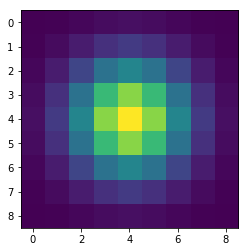

In [6]:
import numpy as np
x, y = np.meshgrid(np.linspace(-1,1,9), np.linspace(-1,1,9))
d = np.sqrt(x*x+y*y)
sigma, mu = 0.4, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
print("2D Gaussian-like array:")
#print(g)
plt.imshow(g)
#print(g.shape)

labels = []
for num, img in enumerate(input_imgs):
    #print(num)
    # Create labels
    #print(metadata[num])
    #print(input_imgs[num])
    label = np.zeros(label_shape)
    coord = coords[num]
    _, input_imgs_w, input_imgs_h = input_imgs[num].numpy().shape
    #print(input_imgs_w, input_imgs_h)
    #print(label_shape)
    
    if coord[0] != None or coord[1] != None:
    #print(coord)
        central = (int(coord[0]/input_imgs_w*label_shape[0]), 
                        int(coord[1]/input_imgs_h*label_shape[1]))
        #print(central)
        #print(central)
        for i in range(-4, 5):
            for j in range(-4, 5):
                lx = min(max(central[1]+i, 0),label_shape[0]-1)
                ly = min(max(central[0]+j, 0),label_shape[1]-1)
                label[lx, ly] += g[i+4, j+4] 
        #show_torch_img(img)
    #plt.show()
    #plt.imshow(label)
    #plt.show()
    #show_torch_img
    labels.append(label)

In [7]:
from torch import FloatTensor
from torch import optim

cf_detector = CoarseFireDetector().cuda()

optimizer = optim.Adam(cf_detector.parameters(), lr = 0.001) 

n_epochs = 3
for i in range(n_epochs):
    for j, (img, label) in enumerate(zip(input_imgs, labels)):
        if j > 27:
            optimizer.zero_grad()
            out = cf_detector(img.cuda().unsqueeze(0))
            #print(out.size())
            weights = np.zeros_like(label)
            weights[label<0.001] = 1.5
            weights[label>=0.001] = 1.0
            loss = torch.mean(FloatTensor(weights).cuda()*(FloatTensor(label).cuda()-out)**2)
            #loss = torch.sum((FloatTensor(label).cuda()-out)**2)
            loss.backward()
            optimizer.step()
            #print(loss.item())


4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


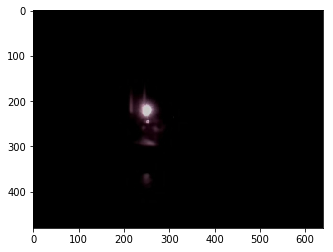

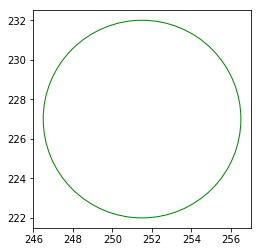

3
ml prediction on current plot (108, 118)


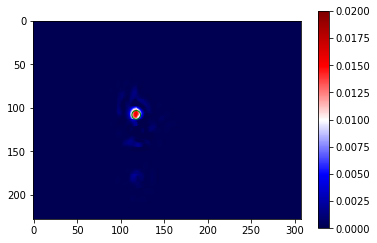

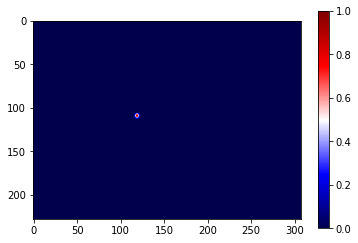

real coords on current plot (109.24375, 119.46249999999999)
distance btwn real and predicted coords on OG image = 4.019840893676885 pixels
distance btwn real and predicted coords on OG image = 0.005627777251147639 millimeters


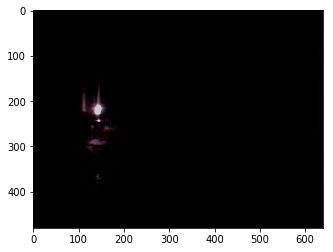

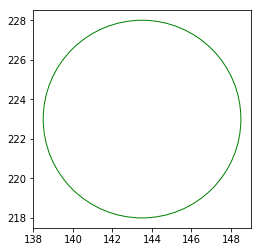

3
ml prediction on current plot (106, 63)


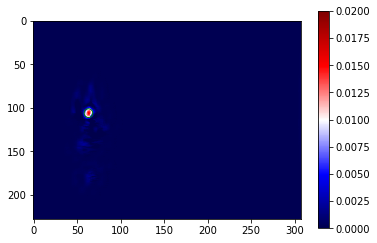

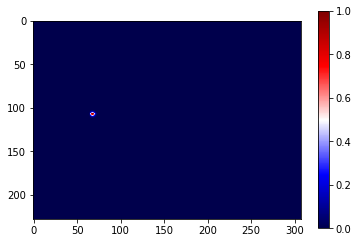

real coords on current plot (107.31875000000001, 68.1625)
distance btwn real and predicted coords on OG image = 11.208550290799133 pixels
distance btwn real and predicted coords on OG image = 0.015691970407118786 millimeters


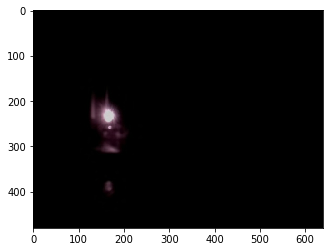

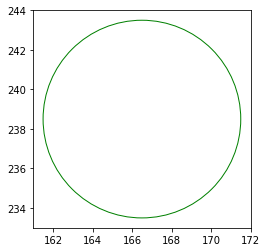

3
ml prediction on current plot (114, 76)


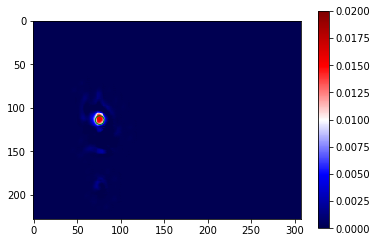

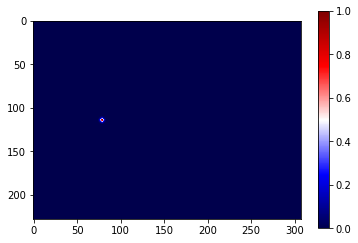

real coords on current plot (114.778125, 79.08749999999999)
distance btwn real and predicted coords on OG image = 6.698082637118003 pixels
distance btwn real and predicted coords on OG image = 0.009377315691965205 millimeters


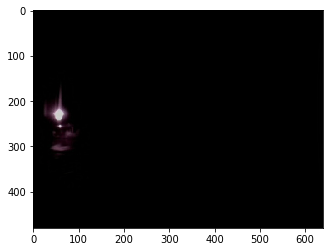

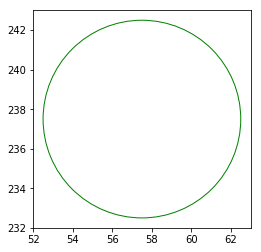

3
ml prediction on current plot (111, 20)


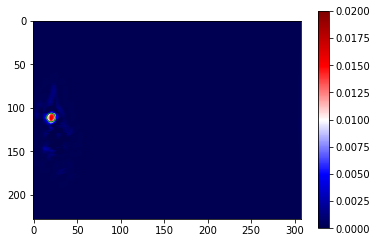

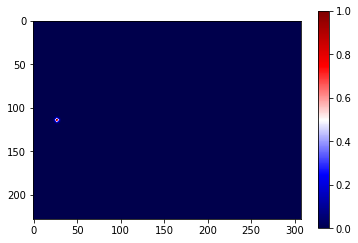

real coords on current plot (114.296875, 27.3125)
distance btwn real and predicted coords on OG image = 16.85020234190751 pixels
distance btwn real and predicted coords on OG image = 0.023590283278670514 millimeters


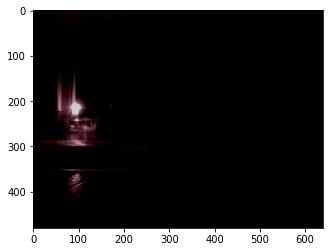

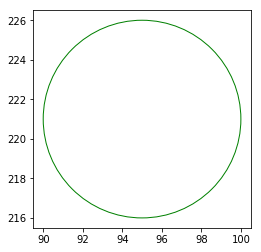

3
ml prediction on current plot (103, 40)


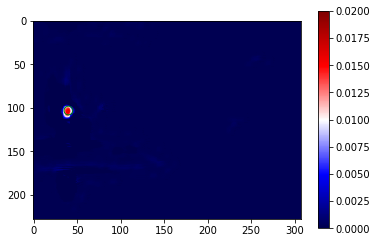

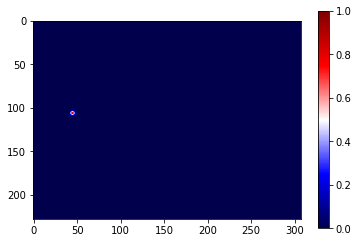

real coords on current plot (106.35625, 45.125)
distance btwn real and predicted coords on OG image = 12.847170142434493 pixels
distance btwn real and predicted coords on OG image = 0.017986038199408288 millimeters


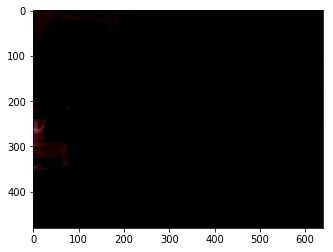

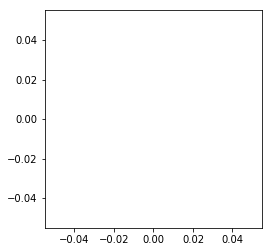

3
ml prediction on current plot (100, 32)


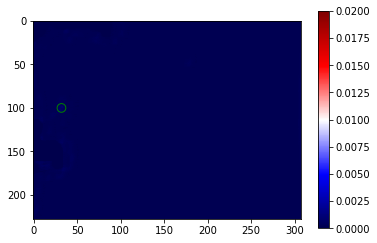

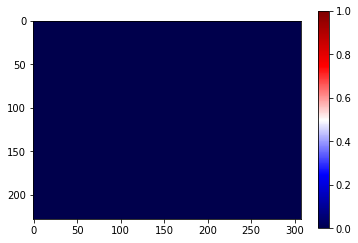

no fire


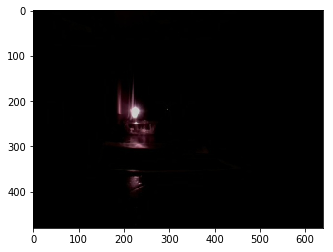

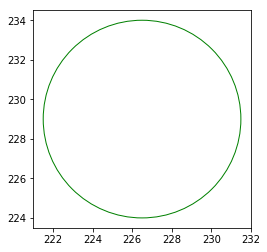

3
ml prediction on current plot (109, 105)


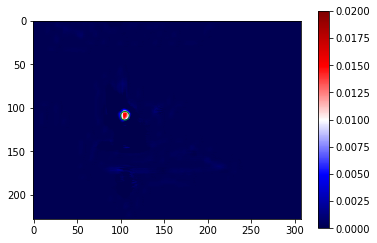

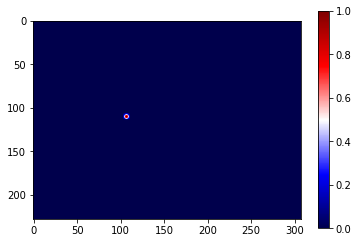

real coords on current plot (110.20625, 107.58749999999999)
distance btwn real and predicted coords on OG image = 5.996359930222298 pixels
distance btwn real and predicted coords on OG image = 0.008394903902311217 millimeters


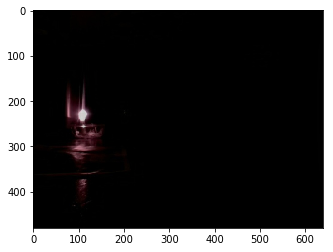

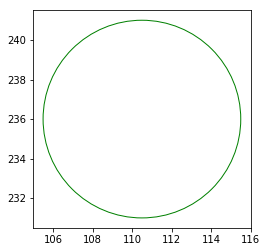

3
ml prediction on current plot (112, 46)


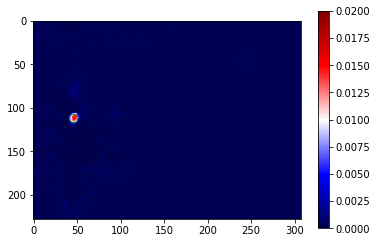

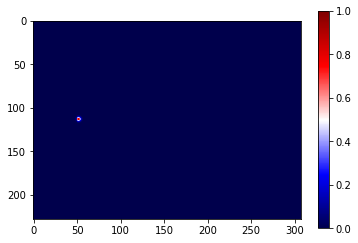

real coords on current plot (113.575, 52.4875)
distance btwn real and predicted coords on OG image = 14.044530339043451 pixels
distance btwn real and predicted coords on OG image = 0.019662342474660827 millimeters


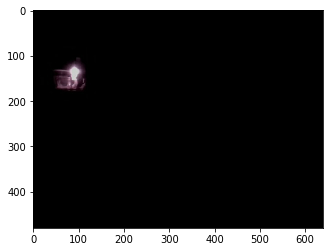

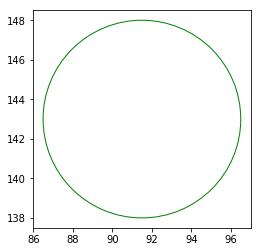

3
ml prediction on current plot (65, 39)


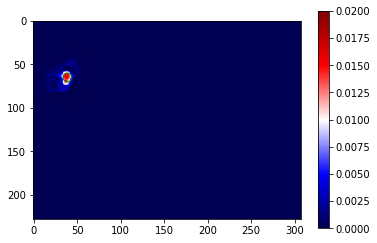

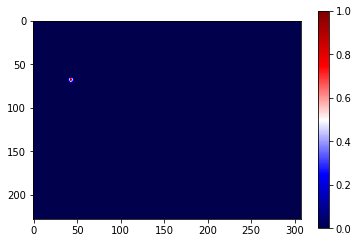

real coords on current plot (68.81875000000001, 43.4625)
distance btwn real and predicted coords on OG image = 12.297411754353309 pixels
distance btwn real and predicted coords on OG image = 0.017216376456094633 millimeters


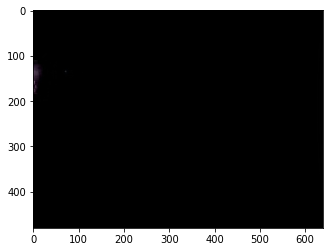

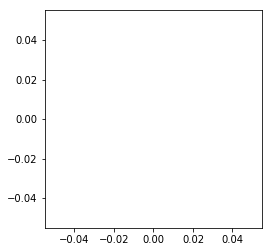

3
ml prediction on current plot (57, 0)


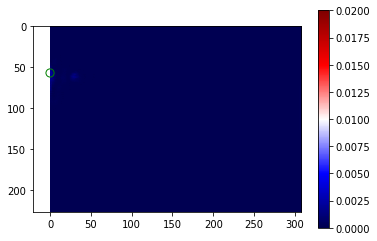

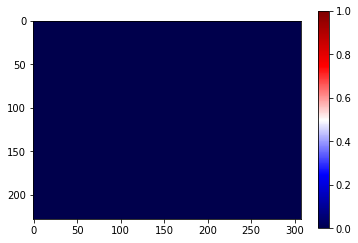

no fire


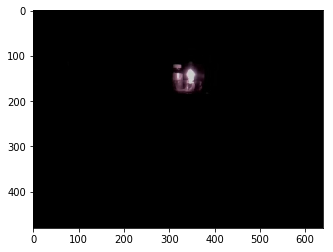

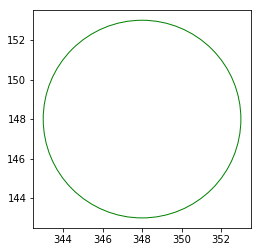

3
ml prediction on current plot (68, 166)


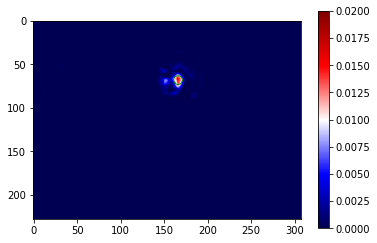

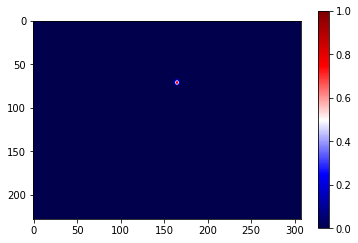

real coords on current plot (71.22500000000001, 165.29999999999998)
distance btwn real and predicted coords on OG image = 6.861424738083359 pixels
distance btwn real and predicted coords on OG image = 0.009605994633316703 millimeters


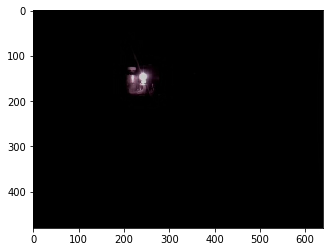

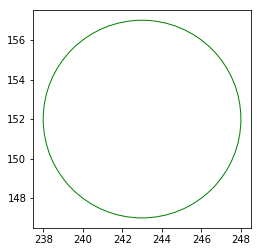

3
ml prediction on current plot (69, 114)


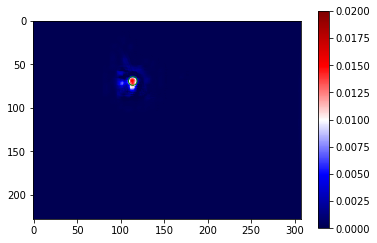

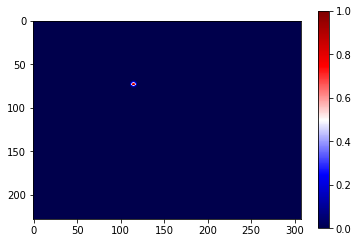

real coords on current plot (73.15, 115.425)
distance btwn real and predicted coords on OG image = 9.13031348796954 pixels
distance btwn real and predicted coords on OG image = 0.012782438883157355 millimeters


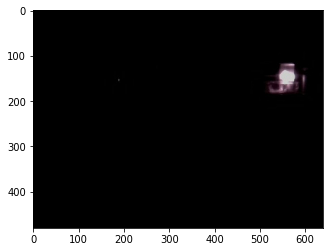

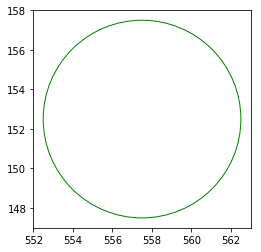

3
ml prediction on current plot (68, 270)


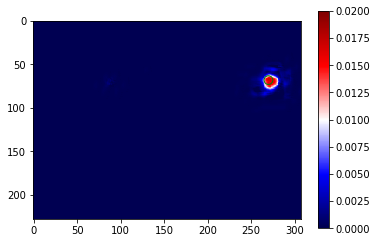

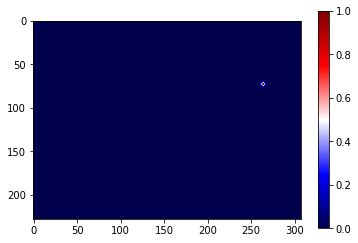

real coords on current plot (73.390625, 264.8125)
distance btwn real and predicted coords on OG image = 15.644119763586367 pixels
distance btwn real and predicted coords on OG image = 0.021901767669020914 millimeters


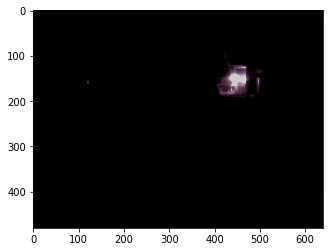

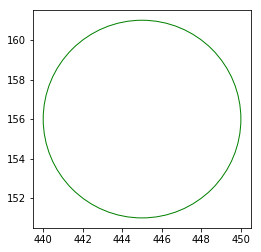

3
ml prediction on current plot (72, 217)


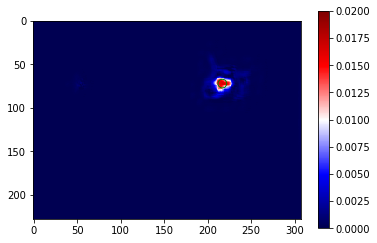

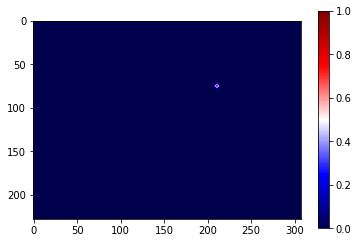

real coords on current plot (75.075, 211.375)
distance btwn real and predicted coords on OG image = 13.455949538948547 pixels
distance btwn real and predicted coords on OG image = 0.018838329354527963 millimeters


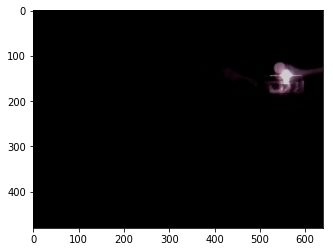

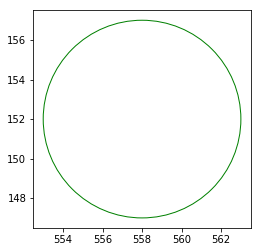

3
ml prediction on current plot (69, 271)


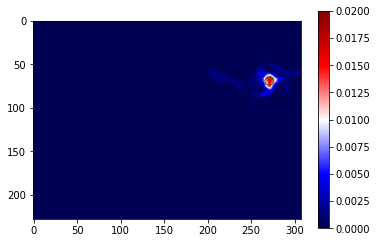

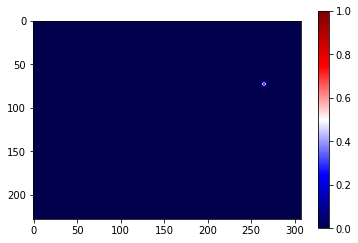

real coords on current plot (73.15, 265.05)
distance btwn real and predicted coords on OG image = 15.20760374438452 pixels
distance btwn real and predicted coords on OG image = 0.021290645242138324 millimeters


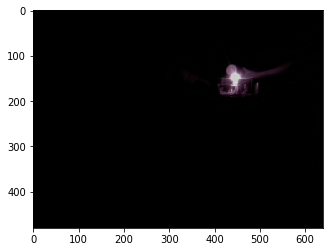

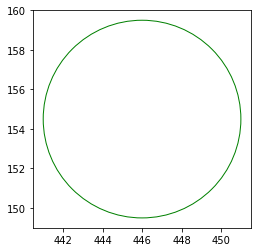

3
ml prediction on current plot (70, 214)


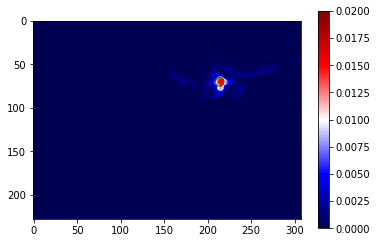

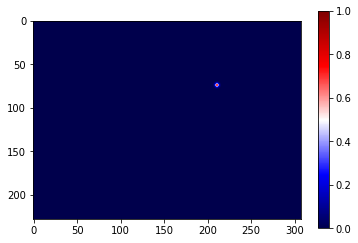

real coords on current plot (74.353125, 211.85)
distance btwn real and predicted coords on OG image = 10.114730968242482 pixels
distance btwn real and predicted coords on OG image = 0.014160623355539474 millimeters


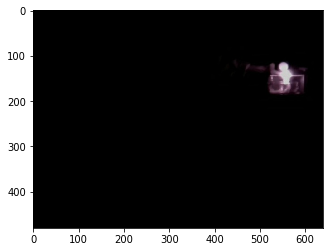

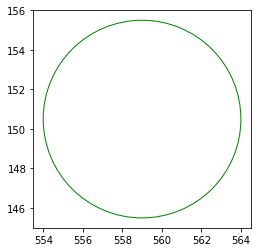

3
ml prediction on current plot (69, 271)


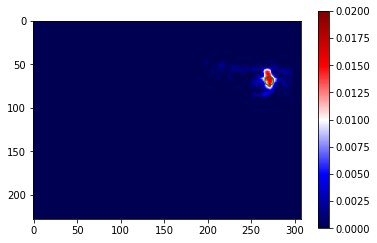

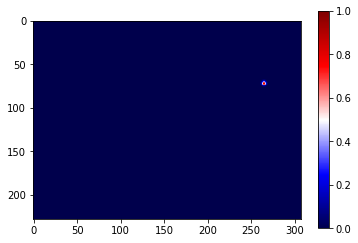

real coords on current plot (72.42812500000001, 265.525)
distance btwn real and predicted coords on OG image = 13.549850559956026 pixels
distance btwn real and predicted coords on OG image = 0.018969790783938435 millimeters


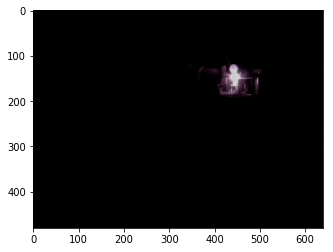

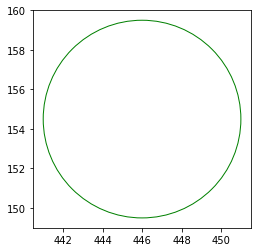

3
ml prediction on current plot (70, 215)


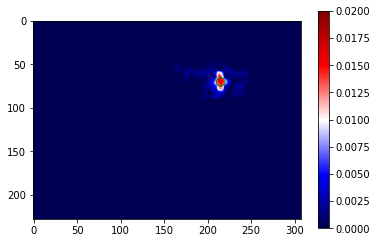

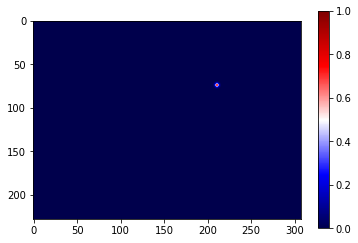

real coords on current plot (74.353125, 211.85)
distance btwn real and predicted coords on OG image = 11.215974646416818 pixels
distance btwn real and predicted coords on OG image = 0.015702364504983544 millimeters


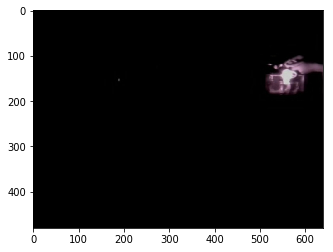

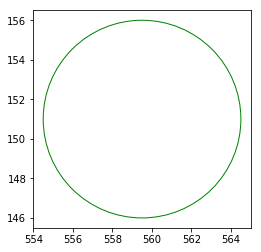

3
ml prediction on current plot (67, 274)


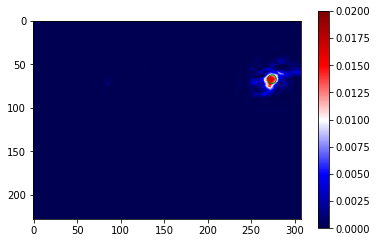

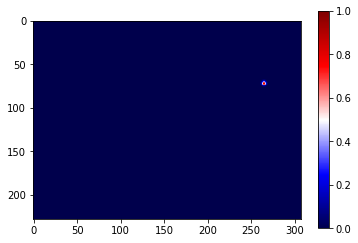

real coords on current plot (72.66875, 265.7625)
distance btwn real and predicted coords on OG image = 20.96422326546053 pixels
distance btwn real and predicted coords on OG image = 0.029349912571644737 millimeters


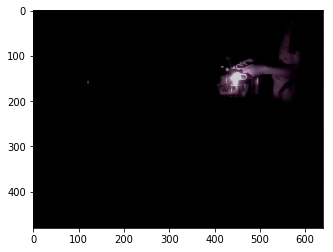

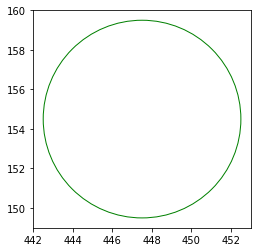

3
ml prediction on current plot (70, 217)


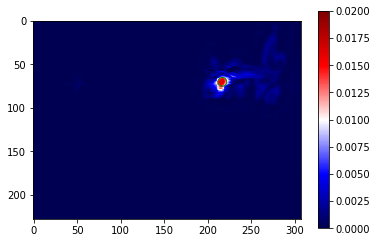

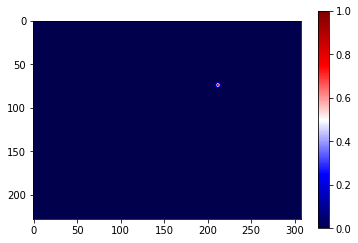

real coords on current plot (74.353125, 212.5625)
distance btwn real and predicted coords on OG image = 13.003660203258445 pixels
distance btwn real and predicted coords on OG image = 0.01820512428456182 millimeters


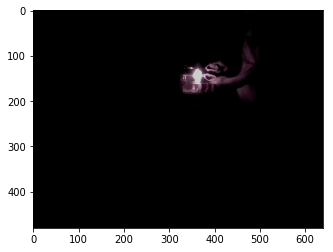

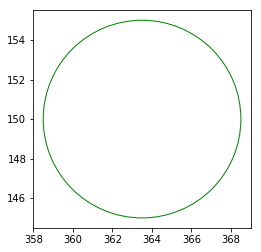

3
ml prediction on current plot (69, 173)


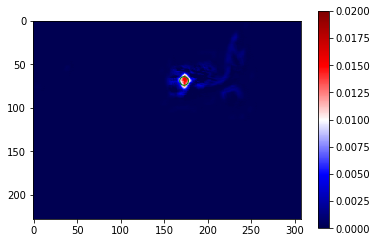

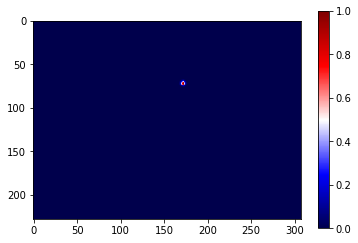

real coords on current plot (72.1875, 172.6625)
distance btwn real and predicted coords on OG image = 6.661378651639716 pixels
distance btwn real and predicted coords on OG image = 0.009325930112295601 millimeters


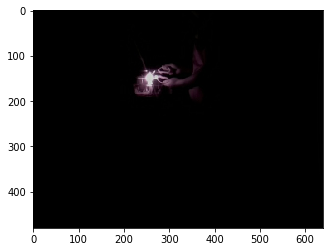

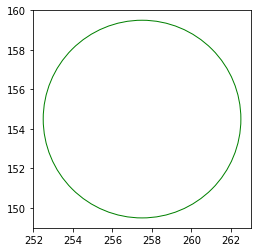

3
ml prediction on current plot (70, 120)


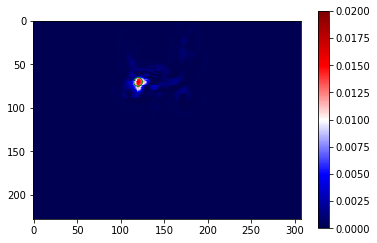

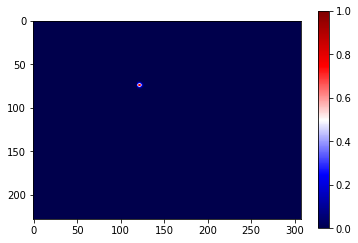

real coords on current plot (74.353125, 122.3125)
distance btwn real and predicted coords on OG image = 10.272379056459647 pixels
distance btwn real and predicted coords on OG image = 0.014381330679043505 millimeters


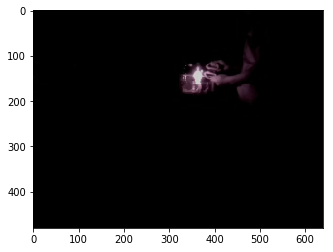

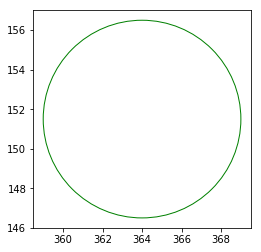

3
ml prediction on current plot (69, 174)


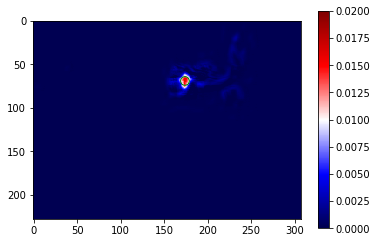

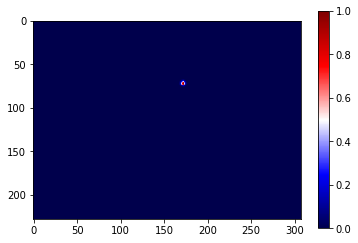

real coords on current plot (72.909375, 172.9)
distance btwn real and predicted coords on OG image = 8.447018920995058 pixels
distance btwn real and predicted coords on OG image = 0.01182582648939308 millimeters


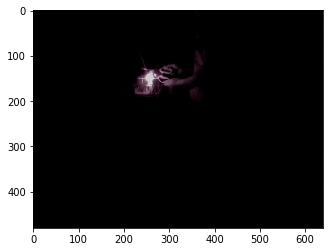

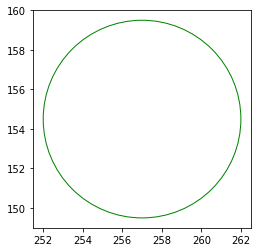

3
ml prediction on current plot (70, 121)


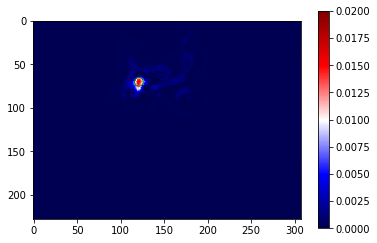

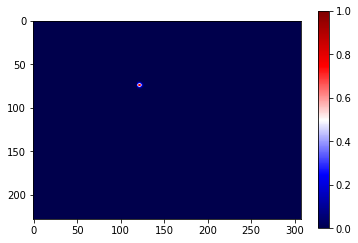

real coords on current plot (74.353125, 122.07499999999999)
distance btwn real and predicted coords on OG image = 9.324276464712646 pixels
distance btwn real and predicted coords on OG image = 0.013053987050597704 millimeters


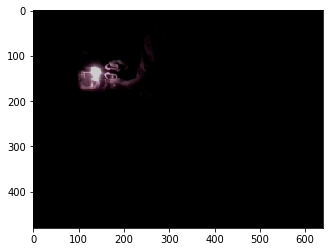

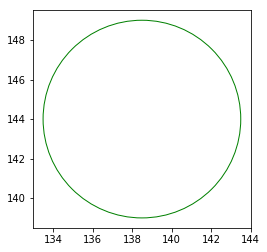

3
ml prediction on current plot (65, 61)


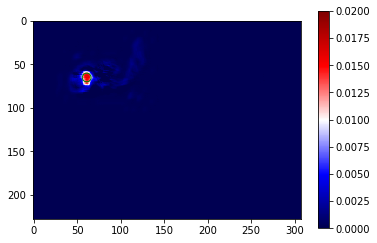

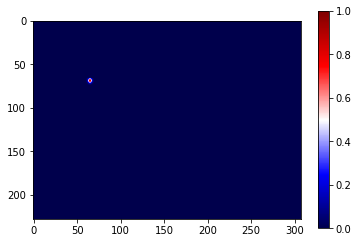

real coords on current plot (69.3, 65.7875)
distance btwn real and predicted coords on OG image = 13.469245169987376 pixels
distance btwn real and predicted coords on OG image = 0.018856943237982326 millimeters


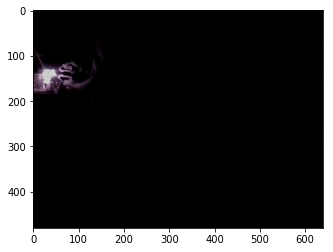

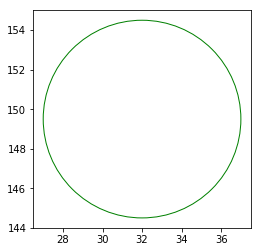

3
ml prediction on current plot (66, 11)


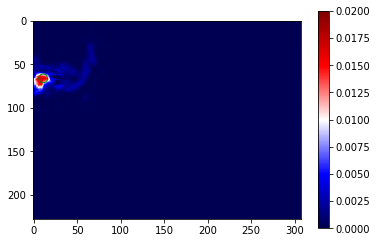

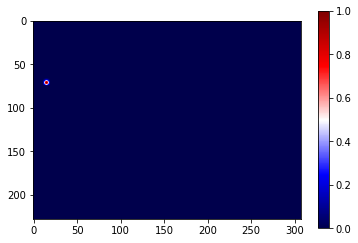

real coords on current plot (71.946875, 15.2)
distance btwn real and predicted coords on OG image = 15.194795328552516 pixels
distance btwn real and predicted coords on OG image = 0.02127271345997352 millimeters


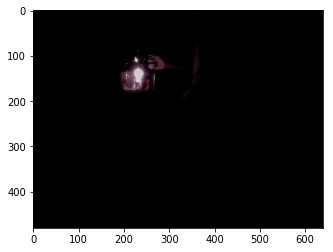

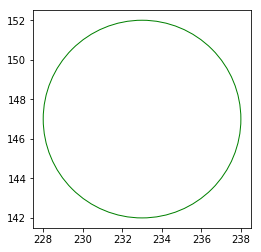

3
ml prediction on current plot (66, 108)


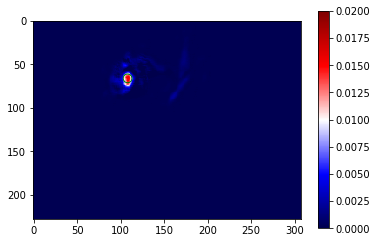

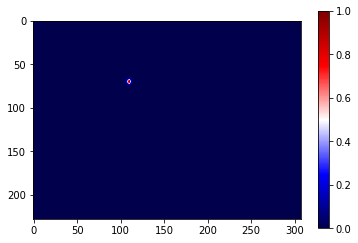

real coords on current plot (70.74375, 110.675)
distance btwn real and predicted coords on OG image = 11.352442325181203 pixels
distance btwn real and predicted coords on OG image = 0.01589341925525368 millimeters


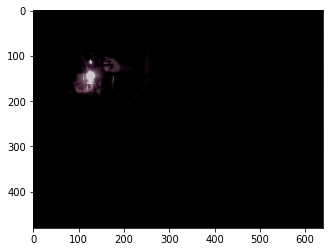

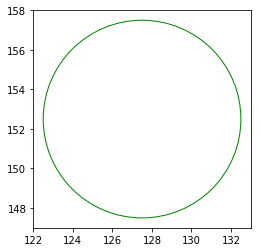

3
ml prediction on current plot (68, 55)


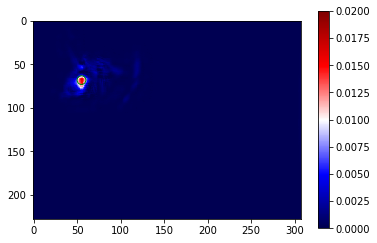

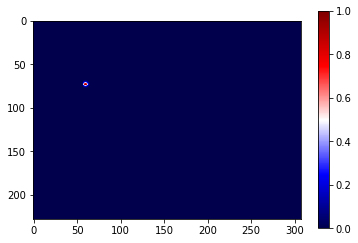

real coords on current plot (73.390625, 60.5625)
distance btwn real and predicted coords on OG image = 16.20510781169053 pixels
distance btwn real and predicted coords on OG image = 0.02268715093636674 millimeters


In [23]:
errdists = []

for ind, (img, label) in enumerate(zip(input_imgs, labels)):
    if ind <= 27:
        show_torch_img(img)
        outline = plt.Circle(coords[ind], 5, color='green', fill=False)
        ax = plt.gca()
        ax.add_patch(outline)
        plt.axis('scaled')
        plt.show()
        
        #show the ML prediction(probability of fire at all points on the image)
        ml_pred = cf_detector.cuda()(img.cuda()).cpu().detach().numpy()
        plt.imshow(ml_pred, cmap="seismic", vmin=0, vmax=0.02)
        
        #get coords of point most likely to be fire according to ML
        (predy, predx) = np.unravel_index(np.argmax(ml_pred), ml_pred.shape)
        print('ml prediction on current plot', (predy, predx))
        #NOTE: above line prints (y, x), NOT (x, y)
        plt.colorbar()
        
        #visually find approximate size of fire according to ml
        outline = plt.Circle((predx, predy), 5, color='green', fill=False)
        ax = plt.gca()
        ax.add_patch(outline)
        plt.axis('scaled')
        plt.show()
        
        #show the human-labelled coordinates
        plt.imshow(label, cmap = "seismic", vmin=0, vmax=1.0)
        plt.colorbar()
        plt.show()
        
        #calculate real coords on new plot/grid
        x_factor = label.shape[0]/input_imgs[ind].shape[1]
        y_factor = label.shape[1]/input_imgs[ind].shape[2]
        if None in coords[ind]:
            print('no fire')
        else:
            realy, realx = coords[ind][1]*y_factor, coords[ind][0]*x_factor
            print('real coords on current plot', (realy, realx))
            #NOTE: above line prints (y, x), NOT (x, y)
            
            #calculate straight-line distance btwn real coords and ML predictions
            #errdist = ( (x_factor*(realx-predx))**2 + (y_factor*(realy-predy))**2 )**0.5
            errdist = ( (predx/x_factor-coords[ind][0])**2 + (predy/y_factor-coords[ind][1])**2 )**0.5
            errdists.append(errdist)
            print('distance btwn real and predicted coords on OG image =', errdist, 'pixels')
            print('distance btwn real and predicted coords on OG image =', np.asarray(errdist)*1.4/1000, 'millimeters')

[4.019840893676885, 11.208550290799133, 6.698082637118003, 16.85020234190751, 12.847170142434493, 5.996359930222298, 14.044530339043451, 12.297411754353309, 6.861424738083359, 9.13031348796954, 15.644119763586367, 13.455949538948547, 15.20760374438452, 10.114730968242482, 13.549850559956026, 11.215974646416818, 20.96422326546053, 13.003660203258445, 6.661378651639716, 10.272379056459647, 8.447018920995058, 9.324276464712646, 13.469245169987376, 15.194795328552516, 11.352442325181203, 16.20510781169053]


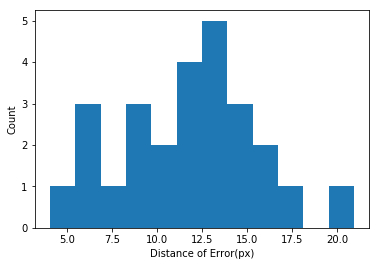

mean distance = 11.693717037503092 px


In [9]:
#plot histogram of distances error
print(errdists)
#plt.hist(errdists, bins=list(range(1,7)))
plt.hist(errdists, bins=12)
plt.xlabel('Distance of Error(px)')
plt.ylabel('Count')
#plt.yticks(range(5))
plt.show()

print('mean distance =', sum(errdists)/len(errdists), 'px')